# Classification with Logistic Regression

## Toy examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_circles

We'll start from a simple 2D dataset that cannot be separated linearly:

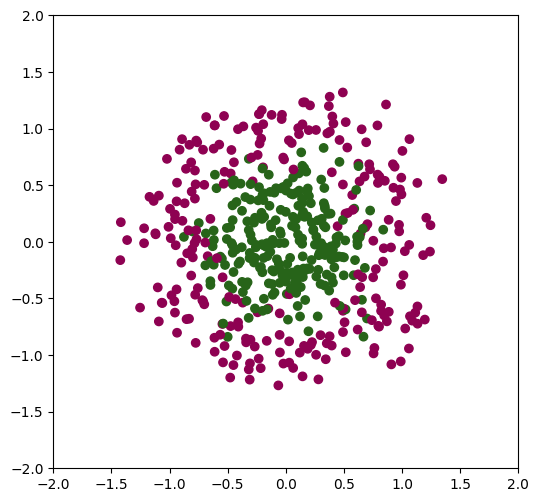

In [3]:
X, y = make_circles(500, noise=0.2, factor=0.4)

def plot_data_and_model_decision(
    X, y,
    model=None,
    x1limits=(-2, 2),
    x2limits=(-2, 2),
    npoints=250
):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.scatter(*X.T, c=y, cmap='PiYG')
    
    plt.xlim(*x1limits)
    plt.ylim(*x2limits)
    
    if model is not None:
        xx1, xx2 = np.meshgrid(
            np.linspace(*x1limits, npoints),
            np.linspace(*x2limits, npoints)
        )
        yy = model.predict(
            np.stack([xx1.ravel(), xx2.ravel()], axis=1)
        ).reshape(xx1.shape)
        
        plt.contourf(xx1, xx2, yy, levels=30, cmap='PiYG', alpha=0.5)

plot_data_and_model_decision(X, y)

This time we'll use the pre-implemented logistic regression model from sklearn:

In [4]:
from sklearn.linear_model import LogisticRegression

Let's create and fit the model:

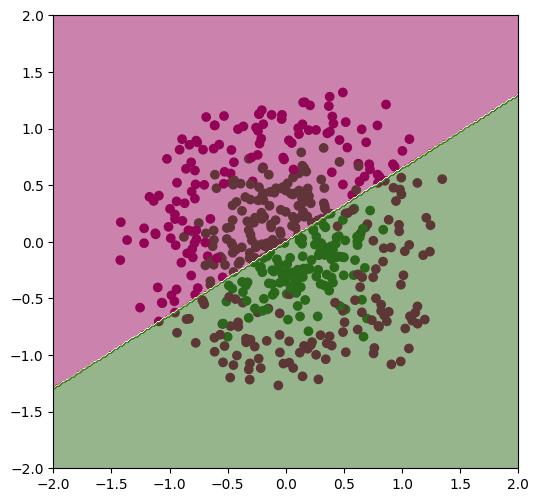

In [5]:
model = LogisticRegression(penalty='none') # We'll discuss different penalty terms in the next lecture.
                                           # So far let's use the model without penalty.
model.fit(X, y)

plot_data_and_model_decision(X, y, model)

Ok, so obviously this model doesn't solve our problem. Let's introduce one more feature to help it:
$$x_3 = x_1^2 + x_2^2$$

Fill the gaps in the code below. The input argument `X` is the design matrix of shape `(N, 2)`, where `N` is the number of objects in the dataset. The output should be a `(N, 3)` matrix with the first two columns of the original matrix and a third column with $x_3$ defined above.

*Hint: you may want to use one of the `np.stack` or `np.concatenate` functions. You can select a single column of `X` by calling `X[:,i]`, or a range of columns `X[:,i:j]`. Alternatively you may use functions like `X.sum(axis=some_axis)`.*

In [6]:
def expand(X):
    ### BEGIN SOLUTION
    return np.stack([
        X[:,0], X[:,1], X[:,0]**2 + X[:,1]**2
    ], axis=1)
    ### END SOLUTION

Once ready, check whether your code passes the assertions below.

In [7]:
dummy_features = np.array([[ 0.21229302, -0.81899763],
                           [ 0.27464688,  1.06161091],
                           [-0.53345235,  0.07886241],
                           [-1.78837706,  0.7757026 ],
                           [ 0.11964808, -1.02261288],
                           [-1.51239009, -2.01744101],
                           [ 0.55670847, -0.90079509],
                           [ 0.01404381,  0.59349316],
                           [ 0.38491586, -1.98926289],
                           [-1.06521045, -0.26742879]])
np.testing.assert_almost_equal(
    expand(dummy_features),
    np.array([[ 0.21229302, -0.81899763,  0.71582544],
              [ 0.27464688,  1.06161091,  1.20244863],
              [-0.53345235,  0.07886241,  0.29079069],
              [-1.78837706,  0.7757026 ,  3.80000703],
              [ 0.11964808, -1.02261288,  1.06005277],
              [-1.51239009, -2.01744101,  6.35739201],
              [ 0.55670847, -0.90079509,  1.12135611],
              [ 0.01404381,  0.59349316,  0.35243136],
              [ 0.38491586, -1.98926289,  4.10532706],
              [-1.06521045, -0.26742879,  1.20619146]])
)

Now we'll make use of sklearn's pipelines! Pipelines allow you to stack different transformations one after another to make your model really powerful. There's a lot of ready to use transformations already implemented in sklearn. As for now, however, we'll define our own for the sake of demonstration:

In [8]:
class MyFeaturesExpansion:
    # `fit` and `transform` are the two required methods to be able
    # to use our transformation in a sklearn pipeline

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return expand(X)

In [9]:
from sklearn.pipeline import make_pipeline

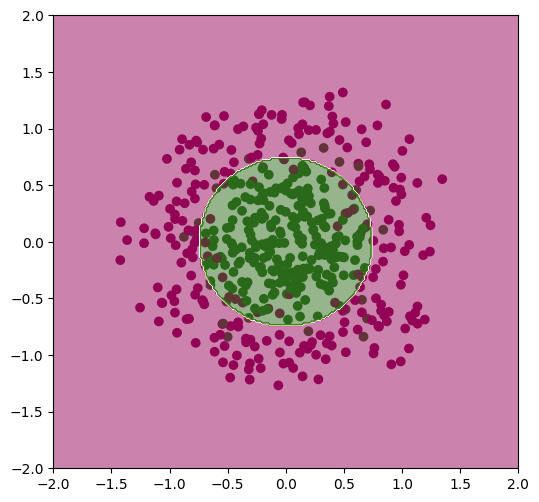

In [10]:
model = make_pipeline(
    MyFeaturesExpansion(),
    LogisticRegression(penalty='none')
)
# A pipeline has the same interface as regular sklearn models (i.e. fit, predict, etc.)
model.fit(X, y)

plot_data_and_model_decision(X, y, model)

Great, so now the problem is solvable!

Note though that this new feature only allows us to have circular decision boundaries, which is not perfect when our data is squeezed or stretched in some direction:

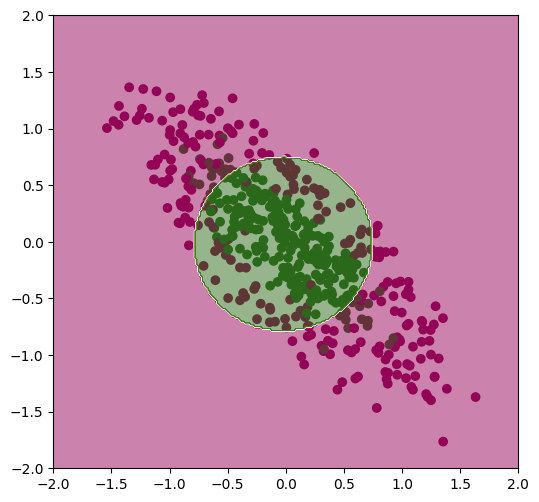

In [11]:
X, y = make_circles(500, noise=0.2, factor=0.4)
X *= [1.5, 0.5]
X = X @ [[0.7, -0.7], [0.7, 0.7]]

model = make_pipeline(
    MyFeaturesExpansion(),
    LogisticRegression(penalty='none')
)
model.fit(X, y)

plot_data_and_model_decision(X, y, model)

In order to make the model more expressive let's use general polynomial feature expansion. That's already implemented in `sklearn.preprocessing.PolynomialFeatures`.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

Now try to make a pipeline of polynomial features expansion + logistic regression model in the code cell below:

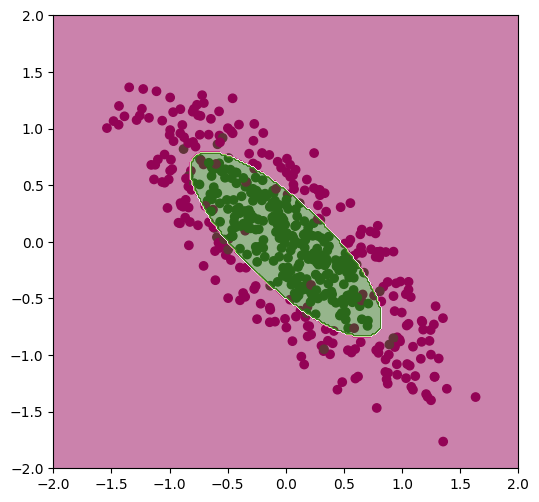

In [13]:
### BEGIN SOLUTION
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegression(penalty='none', max_iter=1000)
)
### END SOLUTION

model.fit(X, y)
plot_data_and_model_decision(X, y, model)

When ready, check that your solution beats the 90% accuracy score threshold:

In [14]:
X, y = make_circles(500, noise=0.2, factor=0.4)
X *= [1.5, 0.5]
X = X @ [[0.7, -0.7], [0.7, 0.7]]

model.fit(X, y)

X, y = make_circles(5000, noise=0.2, factor=0.4)
X *= [1.5, 0.5]
X = X @ [[0.7, -0.7], [0.7, 0.7]]

pred = model.predict(X)

assert (pred == y).mean() > 0.9, (pred == y).mean()

## LHCb particle identification

In this part of the tutorial you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types leave different responses in the detector systems or subdetectors. There are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

You task is to identify a particle type using the responses in the detector systems.

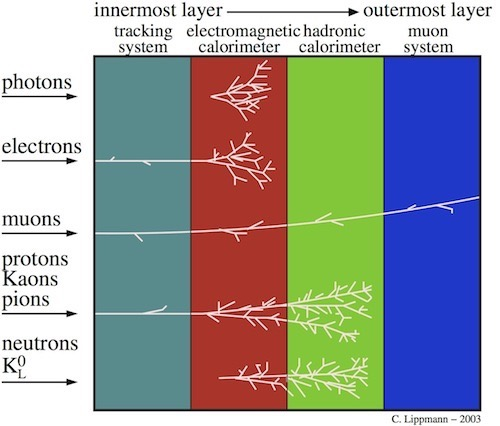

In [15]:
data = pd.read_csv("../../data/1.3.1-logistic-regression/PID-dataset-subsample.csv.gz")

In [16]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,4783.899908,15.0,0.992629,1.0,1.0,3.2,-0.753252,5.095674,1.0,-0.744993,...,25.0,1.0,-0.272898,-9.828998,23413.300773,1.0,1.0,0.000011,12.092303,-2.605698
1,21113.160174,16.0,-0.454772,1.0,1.0,3.2,-3.027843,14.091743,1.0,1.282079,...,28.0,1.0,-78.682187,8.813811,1612.774429,1.0,1.0,2.742716,4.840911,-53.067288
2,2004.359973,14.0,-0.060743,0.0,1.0,0.0,-2.723425,-0.000016,1.0,0.107044,...,27.0,0.0,-0.017021,-33.895621,-999.000000,0.0,0.0,0.000019,-0.000021,-0.000021
3,12877.429683,14.0,-0.638981,0.0,1.0,3.2,-3.283638,4.084645,1.0,0.079914,...,29.0,1.0,13.235793,9.094493,3562.783455,0.0,1.0,1.645638,1.392493,26.947293
4,73979.062493,18.0,0.484596,1.0,1.0,3.2,-2.441371,8.700628,1.0,0.936483,...,36.0,1.0,-2.929998,0.781402,2286.271726,1.0,1.0,2.742734,0.433102,0.430202


In [17]:
data.shape

(60000, 50)

### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost".
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

In [18]:
X = data.drop('Label', axis=1)
y = data['Label']

We'll use sklearns helper funcion to split our data into train and test parts:

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Let's check the data types in the dataset:

In [21]:
X_train.dtypes

TrackP                             float64
TrackNDoFSubdetector2              float64
BremDLLbeElectron                  float64
MuonLooseFlag                      float64
FlagSpd                            float64
SpdE                               float64
EcalDLLbeElectron                  float64
DLLmuon                            float64
RICHpFlagElectron                  float64
EcalDLLbeMuon                      float64
TrackQualitySubdetector2           float64
FlagPrs                            float64
DLLelectron                        float64
DLLkaon                            float64
EcalE                              float64
TrackQualityPerNDoF                float64
DLLproton                          float64
PrsDLLbeElectron                   float64
FlagRICH1                          float64
MuonLLbeBCK                        float64
FlagHcal                           float64
EcalShowerLongitudinalParameter    float64
Calo2dFitQuality                   float64
TrackPt    

### Training logistic regression on the raw data

Even though this isn't a great idea, let's blindly feed this data into a logistic regression model. Linear models like the features to be of roughly the same scale. Let's use sklearn's StandardScaler for it:

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
def print_accuracy(model):
    print('Train accuracy:', (model.predict(X_train) == y_train).mean())
    print('Test accuracy: ', (model.predict(X_test) == y_test).mean())

(e.g. try commenting out the scaler below and check the result)

In [24]:
model_simple = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none')
)
model_simple.fit(X_train, y_train)

print_accuracy(model_simple)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 0.7173333333333334
Test accuracy:  0.71


You've probably got a warning that the solver didn't converge. This is due to the fact that our design matrix has large condition number (e.g. due to correlations between features). Selecting a smaller feature subspace or increasing the number of optimization iterations (`max_iter` argument of the `LogisticRegression` model) may fix it.

### Exploring the data and engineering features

It's always useful to visualize the data

In [25]:
def visualize(feature, target, num_bins=100):
    classes = np.unique(target)
    bins = np.linspace(feature.min(), feature.max(), num_bins + 1)
    for c in classes:
        selection = (target == c)
        plt.hist(feature[selection], bins=bins, label=c, alpha=0.5)
    plt.legend()

Let's visualize some of the columns:

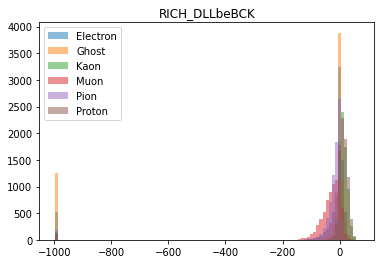

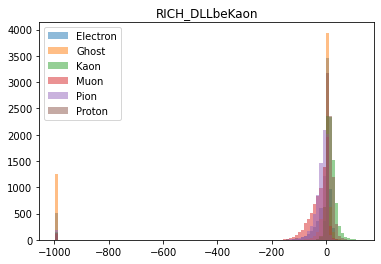

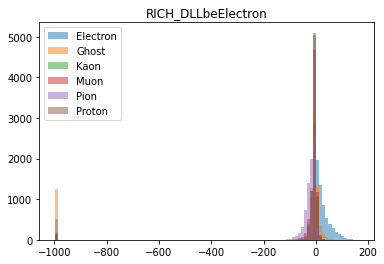

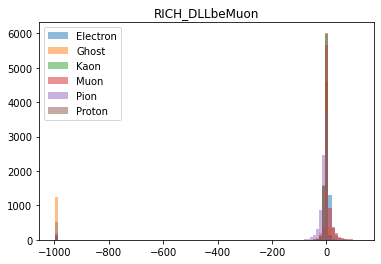

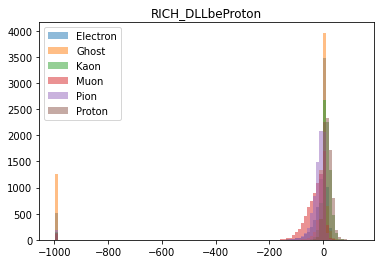

In [26]:
for column in [
    "RICH_DLLbeBCK",
    "RICH_DLLbeKaon",
    "RICH_DLLbeElectron",
    "RICH_DLLbeMuon",
    "RICH_DLLbeProton"
]:
    plt.figure()
    visualize(X_train[column], y_train)
    plt.title(column)

Note that there is some kind of "exit code" in these floating point variables (maybe in others as well? can you check that?). This is not a friendly variable for a linear model. Can you think what you can do with it?

Here's an example feature transformation replacing these values with the mean of the distribution. **Note: this drops potentially important information. A better way might be to also encode these exit codes into new binary features (e.g. `isExitCode_RICH_DLLbeProton`, etc.)**

In [27]:
from sklearn.base import TransformerMixin

class FeatureExpansion(TransformerMixin):
    def __init__(self, dll_threshold=-900):
        super().__init__()

        self.features = [
            "RICH_DLLbeBCK",
            "RICH_DLLbeKaon",
            "RICH_DLLbeElectron",
            "RICH_DLLbeMuon",
            "RICH_DLLbeProton"
        ]
        self.dll_threshold = dll_threshold

    def fit(self, X, y):
        self.mean_vals = [
            X[f][X[f] >= self.dll_threshold].mean()
            for f in self.features
        ]
        return self

    def transform(self, X):
        X = X.copy() # to avoid modifying the original dataset
        
        for f, mean in zip(self.features, self.mean_vals):
            X[f][X[f] < self.dll_threshold] = mean
        
        return X

Here's an example transformation of the train dataset:

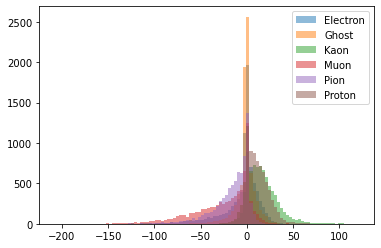

In [28]:
visualize(FeatureExpansion().fit_transform(X_train, y_train)['RICH_DLLbeKaon'], y_train)

In [29]:
model = make_pipeline(
    FeatureExpansion(),
    StandardScaler(),
    LogisticRegression(penalty='none')
)
model.fit(X_train, y_train)

print_accuracy(model)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 0.7276041666666667
Test accuracy:  0.71875


### Quality metrics

As we are doing physics, we should not be satisfied with a single global performance measure. Instead we want to understand the strong and weak sides of our models. For the sake of an example, below there's some code to plot signal efficiency as a function of particle momentum.

In [30]:
import matplotlib

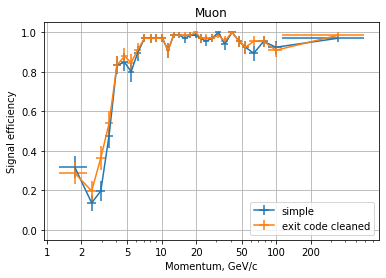

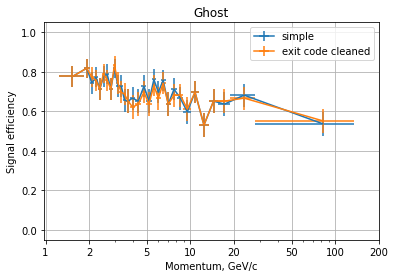

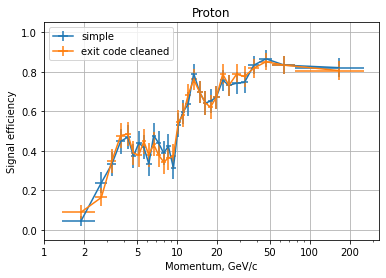

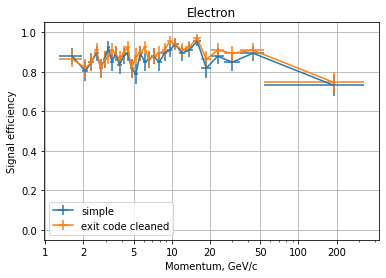

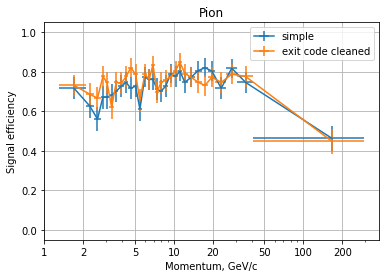

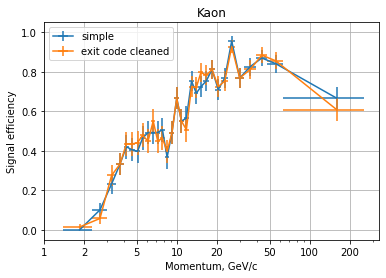

In [31]:
def plot_efficiency(X, y, prediction, particle, **kwargs):
    prediction = (prediction == particle)
    selection = (y == particle)
    p = X['TrackP'] / 1000.
    
    tmp_dataset = pd.DataFrame({'p' : p[selection], 'prediction' : prediction[selection]})
    tmp_dataset['p_bin'] = pd.qcut(tmp_dataset['p'], 30)
    
    group = tmp_dataset.groupby('p_bin')['prediction']
    efficiency = group.mean()
    efficiency_err = group.std() / group.count()**0.5
    
    p_mid = efficiency.index.categories.mid
    p_err = (efficiency.index.categories.right - efficiency.index.categories.left) / 2
    
    plt.errorbar(
        x=p_mid,
        y=efficiency,
        xerr=p_err,
        yerr=efficiency_err,
        **kwargs
    )
    plt.grid(True)
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().set_xticks([1, 2, 5, 10, 20, 50, 100, 200])
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Momentum, GeV/c')
    plt.ylabel('Signal efficiency')

for particle in y.unique():
    plt.figure()
    plot_efficiency(X_test, y_test, model_simple.predict(X_test), particle, label='simple')
    plot_efficiency(X_test, y_test, model.predict(X_test), particle, label='exit code cleaned')
    plt.legend()
    plt.title(particle)

### Things to try

To improve the scores and efficiencies you may want to try the following things:

 - **Feature selection** (are we really benefiting from this many features?)
 - **Fix other exit codes** (can you find all variables with exit codes and transform them?)
 - **Polynomial expansion** (can we find useful feature interactions that would boost up the quality of the model?)
 - **PCA** (principal component analysis, as implemented in `sklearn.decomposition.PCA` - this method allows you to find an orthogonal basis in the feature space, and also to sort the new features based on their variance; it may help stabilize the learning + gives you the means of selecting the most informative features)